In [1]:
import os
import sys
sys.path.insert(0, '/global/homes/k/kovacs/gcr-catalogs_diffsky_v0.1')
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import astropy.constants
from astropy.constants import iaudata
from astropy import units as u
import GCRCatalogs

# Load catalog, define parameter names and define some useful constants

In [2]:
gc = GCRCatalogs.load_catalog('diffsky_v0.1_p3765_vsmall')
native_quantities = sorted(gc.list_all_native_quantities())
from lsstdesc_diffsky.constants import MAH_PNAMES, MS_U_PNAMES, Q_U_PNAMES
print(MAH_PNAMES, MS_U_PNAMES, Q_U_PNAMES)
DUST_PNAMES = ['dust_Eb', 'dust_delta', 'dust_Av']
met_names = [n for n in native_quantities if 'met' in n]
print(gc.cosmology)

In [55]:
ERG_PER_JOULE = 1e7
CM_PER_MPC = 3.085677581491367e+24

In [4]:
#Compute times
T0 = gc.cosmology.age(0.0).value
LGT0 = np.log10(T0)
times = np.linspace(0.1, T0, 100)

## Load SSP data

In [80]:
DSPS_data_dir = '/global/cfs/cdirs/lsst/groups/CS/Catalog_5000/dsps_data/FSPS_ssp_data/'
DSPS_data_fn = 'ssp_data_fsps_v3.2_lgmet_age.h5'
from dsps.data_loaders.load_ssp_data import load_ssp_templates
ssp_data = load_ssp_templates(fn=os.path.join(DSPS_data_dir, DSPS_data_fn))
print(ssp_data._fields)

('ssp_lgmet', 'ssp_lg_age_gyr', 'ssp_wave', 'ssp_flux')


# Load catalog data and select subsample of red and blue galaxies

In [41]:
cat_data = gc.get_quantities(MAH_PNAMES + MS_U_PNAMES + Q_U_PNAMES + DUST_PNAMES + met_names + ['redshift', 'mag_r', 'mag_i'])

In [42]:
import pandas as pd
df = pd.DataFrame(cat_data)

In [44]:
df['r-i'] = df['mag_r'] -  df['mag_i']
red_mask = (df['r-i'] > 1.5) &  (df['redshift'] < 1.0)
print(np.count_nonzero(red_mask))
blue_mask = (df['r-i'] < 0.0) &  (df['redshift'] < 1.0)
print(np.count_nonzero(blue_mask))

746
337


# Retrieve diffmah/diffstar parameters and compute SFHs

In [46]:
mah_params = np.array([df[_] for _ in MAH_PNAMES]).T
ms_u_params = np.array([df[_] for _ in MS_U_PNAMES]).T
q_u_params = np.array([df[_] for _ in Q_U_PNAMES]).T
#q_u_params = assemble_param_arrays(cat_data, Q_U_PNAMES)
print(mah_params.shape, ms_u_params.shape, q_u_params.shape)

(19333976, 4) (19333976, 5) (19333976, 4)


In [47]:
from lsstdesc_diffsky.photometry.get_SFH_from_params import get_sfh_from_params
sfh_red = get_sfh_from_params(mah_params[red_mask], ms_u_params[red_mask], q_u_params[red_mask], LGT0, times)
sfh_blue = get_sfh_from_params(mah_params[blue_mask], ms_u_params[blue_mask], q_u_params[blue_mask], LGT0, times)
print(sfh_red.shape, sfh_blue.shape)

.......computing SFHs from diffmah/star params for 100 times
.......using parameters with shapes (746, 4), (746, 5), (746, 4)
.......computing SFHs from diffmah/star params for 100 times
.......using parameters with shapes (337, 4), (337, 5), (337, 4)
(746, 100) (337, 100)


# Define function to return galaxy SED
# Thanks to Jim Chiang for contributing this function.
# Note the unit conversions required to produce a galsim SED.

In [74]:
import galsim
from dsps import calc_rest_sed_sfh_table_lognormal_md
def evaluate_rest_sed(galaxy_data, ssp_data, gal_sfh_table, t_table, redshift='redshift'):
    """Return the rest-frame SED of the galaxy."""
    zz = galaxy_data[redshift]
    t_obs = gc.cosmology.lookback_time(zz)
    
    gal_lgmet = galaxy_data['lg_met_mean']
    gal_lgmet_scatter = galaxy_data['lg_met_scatter']
    
    sed_args = (t_table,
                gal_sfh_table,
                gal_lgmet,
                gal_lgmet_scatter,
                ssp_data.ssp_lgmet,
                ssp_data.ssp_lg_age_gyr,
                ssp_data.ssp_flux,
                t_obs,
                )

    rest_sed = calc_rest_sed_sfh_table_lognormal_mdf(*sed_args)
    
    #rest_sed = calc_rest_sed_sfh_table_met_table(*sed_args)  #with metallicity history
                            
    #dust_params = np.array([galaxy_pars[_] for _ in DUST_PNAMES])
    #atten = _get_att_curve_kern(ssp_data.ssp_wave, dust_params)
    atten = 1.0
    
    Lnu = np.array(rest_sed.rest_sed*atten)  # Lsun/Hz

    # Collect conversion factors = L_sun*ergs_per_joule*clight/4./pi/dl**2
    clight = astropy.constants.c.value*1e2  # cm/s
    dl = gc.cosmology.luminosity_distance(zz).value*CM_PER_MPC
    factor = iaudata.L_sun.value*ERG_PER_JOULE*clight/4/np.pi/dl**2

    wl = ssp_data.ssp_wave*1e-8  # convert from Angstroms to cm
    Flambda = Lnu*factor/wl**2
    lut = galsim.LookupTable(ssp_data.ssp_wave, Flambda)
    return galsim.SED(lut, wave_type=u.Angstrom, flux_type='flambda')

# Compute and plot some sample SEDs for color-selected galaxies

In [82]:
gals_red = df[red_mask]
gals_blue = df[blue_mask]

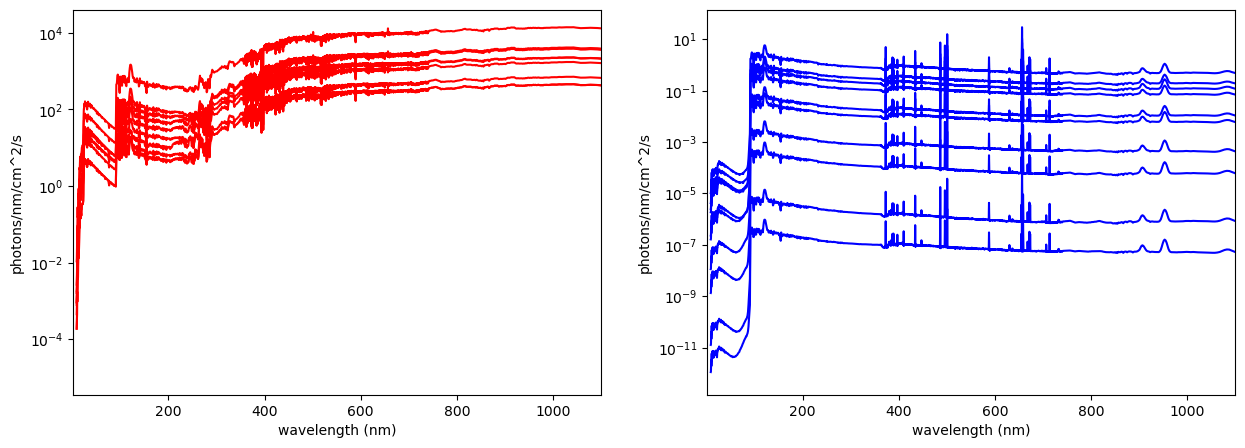

In [83]:
fig, ax_all = plt.subplots(1, 2, figsize=(15, 5))
for ax, gals, sfh, c in zip(ax_all.flat, [gals_red, gals_blue], [sfh_red, sfh_blue], ['r', 'blue']):
    for __ in range(10):
        iplot = np.random.randint(0, len(gals))
        sed = evaluate_rest_sed(gals.iloc[iplot], ssp_data, sfh[iplot], times)
        sed_values = sed(sed.wave_list)
        ax.plot(sed.wave_list, sed_values, color=c)
        
    ax.set_yscale('log')
    ax.set_xlim(1, 1100)
    #ax.set_ylim(1e-5, 1e4)
    ax.set_xlabel('wavelength (nm)')
    ax.set_ylabel('photons/nm/cm^2/s')
 